# **Set Up**
Before running this notebook, the file ***BregmanLearning*** in the file ***codes*** should be uploaded. The file is included in the submission
Make sure to change the mode of runnung to GPU

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!pip install torchviz
%cd BregmanLearning

Cloning into 'BregmanLearning'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 376 (delta 16), reused 4 (delta 4), pack-reused 350
Receiving objects: 100% (376/376), 202.70 KiB | 5.79 MiB/s, done.
Resolving deltas: 100% (218/218), done.
/content/BregmanLearning


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from utils.datasets import get_data_set, GaussianSmoothing
from models.fully_connected import fully_connected
from models.resnet import ResNet18
from models.mnist_conv import mnist_conv


# **Fully-connected Net** (SECTION 4.2 in the paper)

**This part is used to reproduce the result stated in section 4.2 where different optimzers on two layers MLP**

In [ ]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from models.fully_connected import fully_connected

In [ ]:
random_seed = 2
cf.seed_torch(random_seed)


## **MODEL init**

In [ ]:
sparse_init = 0.01
r = [1,0.7/math.sqrt(sparse_init)]

conf_args = {#
    # data specification
    'data_file':"../../Data", 'train_split':0.95, 'data_set':"MNIST", 'download':True,
    # cuda
    'use_cuda':True, 'num_workers':4, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda':1e-3, 'optim':"LinBreg",'beta':0.0,
    # initialization
    'sparse_init':sparse_init, 'r':r,
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

sizes = [784, 200, 80, 10]
act_fun = torch.nn.ReLU()
    
model = fully_connected(sizes, act_fun, **model_kwargs)
best_model = train.best_model(fully_connected(sizes, act_fun, **model_kwargs).to(conf.device))


In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_weight_normal_(model, conf.r[1])
    
    maf.sparsify_(model, conf.sparse_init)
    model = model.to(conf.device)
    return model

model = init_weights(conf,model)

## **OPTIMIZER**

In [ ]:
def init_opt(conf, model):
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)

    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda), 'momentum':conf.beta, 'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "adam":
        opt = op.AdamBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

## **DATASET**

In [ ]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

OSError: ignored

## **Training**

In [ ]:
# Initialize history
tracked = ['acc', 'loss', 'linear_sparse', 'reg_vals']

def reset_hist(tracked):
    train_hist = {}
    val_hist = {}
    return train_hist, val_hist

# Initialize runs
params = [
    # LinBreg Runs
    {'optim': 'LinBreg','reps':1, 'lamda': 1e-3, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-3)'}, # LinBreg, lamda:1e-3
    {'optim': 'LinBreg','reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-1)'}, # LinBreg, lamda:1e-1
    {'optim': 'LinBreg','reps':1, 'lamda': 1e-2, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-2)'}, # LinBreg, lamda:1e-2
    # SGD Runs (Equivalent to LinBreg with lamda = 0.0)
    {'optim': 'LinBreg','reps':1, 'lamda': 0.0, 'random_seed':0, 'label':'SGD'}, # SGD
    # ProxGD Runs
    {'optim': 'ProxSGD','reps':1, 'lamda': 1e-4, 'random_seed':0, 'label':'ProxSDG ($\lambda=1$e-4)'}, # ProxSGD, lamda:1e-4
    {'optim': 'ProxSGD','reps':1, 'lamda': 1e-5, 'random_seed':0, 'label':'ProxSDG ($\lambda=1$e-5)'}, # ProxSGD, lamda:1e-3
    {'optim': 'ProxSGD','reps':1, 'lamda': 1e-3, 'random_seed':0, 'label':'ProxSDG ($\lambda=1$e-3)'}, # ProxSGD, lamda:1e-4
]

runs = cf.run(params)


In [ ]:
train_accuracy_MO1 = []
val_accuracy_MO1 = []

In [ ]:
while runs.step(conf):
    # -----------------------------------------------------------------------------------
    # Reinit weigts and the corresponding optimizer
    # -----------------------------------------------------------------------------------
    train_hist, val_hist = reset_hist(tracked)
    model = init_weights(conf, model)
    opt, scheduler = init_opt(conf, model)
    
    # -----------------------------------------------------------------------------------
    # train the model
    # -----------------------------------------------------------------------------------
    for epoch in range(conf.epochs):
        print(25*"<>")
        print(50*"|")
        print(25*"<>")
        print('Epoch:', epoch)

        # ------------------------------------------------------------------------
        # train step, log the accuracy and loss
        # ------------------------------------------------------------------------
        train_data = train.train_step(conf, model, opt, train_loader)

        # update history
        for key in tracked:
            if key in train_data:
                var_list = train_hist.setdefault(key, [])
                var_list.append(train_data[key])        

        # ------------------------------------------------------------------------
        # validation step
        val_data = train.validation_step(conf, model, opt, valid_loader)
        for key in tracked:
            
            
            if key in val_data:
                var = val_data[key]
                if isinstance(var, list):
                    for i, var_loc in enumerate(var):
                        key_loc = key+"_" + str(i)
                        var_list = val_hist.setdefault(key_loc, [])
                        val_hist[key_loc].append(var_loc)
                else:
                    var_list = val_hist.setdefault(key, [])
                    var_list.append(var)    

        # scheduler step
        scheduler.step(train_data['loss'])
        print("Learning rate:",opt.param_groups[0]['lr'])
        
        # update beset model
        best_model(train_data['acc'], val_data['acc'], model=model)

        
    # add values to the run history
    runs.add_history(train_hist, "train")
    runs.add_history(val_hist, "val")
            
    # update random seed
    cf.seed_torch(conf.random_seed)


<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


流式输出内容被截断，只能显示最后 5000 行内容。
Linear sparsity: 0.9999884792626728
Overall sparsity: 0.9999884792626728
Node sparsity: [1.0, 1.0, 1.0]
Regularization values per group: [0.0, 0.0]
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 67
--------------------------------------------------
Train Accuracy: 0.9999824561403509
Train Loss: 0.14900885859970003
--------------------------------------------------
Validation Accuracy: 0.979
Non-zero kernels: 0
Linear sparsity: 0.9999884792626728
Overall sparsity: 0.9999884792626728
Node sparsity: [1.0, 1.0, 1.0]
Regularization values per group: [0.0, 0.0]
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 68
--------------------------------------------------
Train Accuracy: 0.9999824561403509
Train Loss:

## **drawing**

In [ ]:
import json

hist = runs.history

with open('data_4.2.json', 'w') as fp:
    json.dump(hist, fp)

In [ ]:
import numpy as np

hist = runs.history
keys = ['train_acc','val_acc','val_reg_vals_0','val_linear_sparse']


hist_idx = 0
for param in params:
    data = {}
    for key in keys:
        if not key in hist[hist_idx]:
            continue
        
        if key == 'train_acc' or key == 'val_acc' or key == 'val_linear_sparse':
            rescale = 100
        else:
            rescale = 1/param['lamda'] if param['lamda'] > 0.0 else 0.0
            
        n = len(hist[hist_idx][key])
        m = param.get('reps',1)
        data_loc = np.zeros(shape=(n,m))
        
        # assign data and save it into local array for mean and average
        for i in range(m):
            var = np.array(hist[hist_idx + i][key])
            data_loc[:,i] = rescale*var
            data[key+"_run_" + str(i)] = rescale*var
            print(data_loc[:,i])

        # mean and std of the data
        data[key+"_mean"] = np.mean(data_loc,axis=1)
        data[key+"_std"] = np.std(data_loc,axis=1)
        
        param['result'] = data
        
        # update the history index
    hist_idx += m

[85.84210526 94.20877193 95.85263158 96.72280702 97.41754386 97.9245614
 98.15263158 98.35438596 98.71929825 98.92105263 99.11403509 99.23157895
 99.43333333 99.53508772 99.69122807 99.78421053 99.83157895 99.92105263
 99.95614035 99.95438596 99.97192982 99.98245614 99.98596491 99.9877193
 99.98947368 99.9877193  99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368 99.98947368
 99.98947368 99.98947368 99.98947368 99.98947368 99.9

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

In [ ]:
def plot_training_stats(ax, keys, data, label='', color='k',alpha=1.0, alpha_fill=0.2):
    for i in range(len(keys)):
        if not (keys[i]+'_mean') in data:
            continue
        # --------------------------------
        var_mean = data[keys[i]+'_mean']
        var_std = data[keys[i]+'_std']
        # --------------------------------
        epochs = np.arange(len(var_mean))
        ax[i].plot(epochs,var_mean, label=label, color=color,alpha=alpha)
        ax[i].fill_between(epochs, var_mean - var_std, var_mean + var_std, color=color, alpha=alpha_fill)

In [ ]:
cmp = matplotlib.cm.get_cmap(name='Accent')
colors = [
    cmp(0.7), #
    cmp(0.4), #
    cmp(0.0), #
    cmp(0.2), #
    cmp(0.8), #
    cmp(0.3), #
    cmp(0.1), #
]

for i, param in enumerate(params):
    param['color'] = colors[i]
    param.setdefault('label', param['optim'])

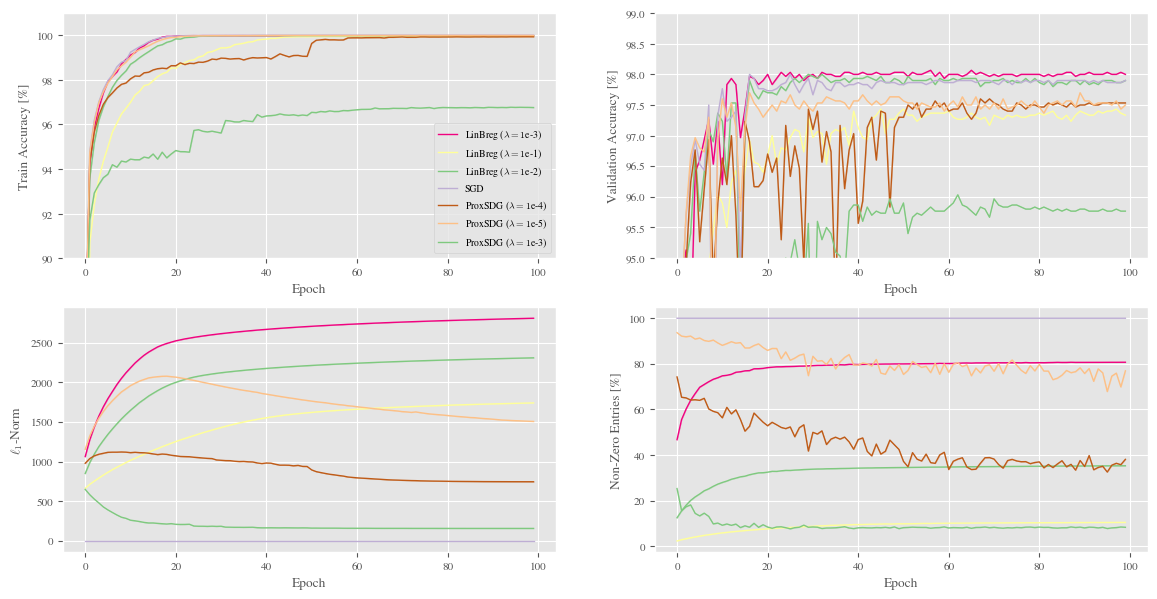

In [ ]:
fig, ax = plt.subplots(2,2)
ax = np.ravel(ax)

for param in params:
    plot_training_stats(ax, keys, param['result'], color = param['color'], label = param['label'])

# Specify axes
## Train Acc
ax[0].set_ylabel('Train Accuracy [%]')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(90, 101)
## Validation Acc
ax[1].set_ylabel('Validation Accuracy [%]')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(95, 99)
## L1-Norm
ax[2].set_ylabel('$\ell_1$-Norm')
ax[2].set_xlabel('Epoch')
## Sparsity
ax[3].set_ylabel('Non-Zero Entries [%]')
ax[3].set_xlabel('Epoch');

# Legend
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='best',frameon=1,prop={'size': 7}, ncol = 1)

# Adjust size
width = 14
height = 7
fig.set_size_inches(width, height)

fig.savefig("4.2.png")

# **Fully-connected Net** (SECTION 4.3 in the paper)

In [ ]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from models.fully_connected import fully_connected

In [ ]:
random_seed = 2
cf.seed_torch(random_seed)

## **MODEL init**

In [ ]:
sparse_init = 0.01
r = [1,0.7/math.sqrt(sparse_init)]

conf_args = {#
    # data specification
    'data_file':"../../Data", 'train_split':0.95, 'data_set':"MNIST", 'download':True,
    # cuda
    'use_cuda':True, 'num_workers':4, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda':1e-3, 'optim':"LinBreg",'beta':0.0,
    # initialization
    'sparse_init':sparse_init, 'r':r,
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

sizes = [784, 200, 80, 10]
act_fun = torch.nn.ReLU()
    
model = fully_connected(sizes, act_fun, **model_kwargs)
best_model = train.best_model(fully_connected(sizes, act_fun, **model_kwargs).to(conf.device))


In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_weight_normal_(model, conf.r[1])
    
    maf.sparsify_(model, conf.sparse_init)
    model = model.to(conf.device)
    return model

model = init_weights(conf,model)

## **OPTIMIZER**

In [ ]:
def init_opt(conf, model):
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)

    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda), 'momentum':conf.beta, 'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "LinBregM":
        opt = op.LinBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda), 'momentum':0.9, 'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':0.9}])  
    elif conf.optim == "adam":
        opt = op.AdamBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                           {'params': biases, 'lr': conf.lr}])
    
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

## **DATASET**

In [ ]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../../Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../Data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **Training**

In [ ]:
# Initialize history
tracked = ['acc', 'loss', 'linear_sparse', 'reg_vals']

def reset_hist(tracked):
    train_hist = {}
    val_hist = {}
    return train_hist, val_hist

# Initialize runs
params = [
    # SGD Runs (Equivalent to LinBreg with lamda = 0.0)
    {'optim': 'LinBreg','reps':1, 'lamda': 0.0, 'random_seed':0, 'label':'SGD'}, # SGD
    
    # LinBreg Runs
    {'optim': 'LinBreg', 'reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'LinBreg'}, # LinBreg, lamda:1e-1
    {'optim': 'LinBregM', 'reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'LinBreg with Momentum'}, # LinBreg, lamda:1e-1
    
    # AdaBreg Runs
    {'optim': 'AdaBreg', 'reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'AdaBreg'}, # AdaBreg
]

runs = cf.run(params)


In [ ]:
train_accuracy_MO1 = []
val_accuracy_MO1 = []

In [ ]:
while runs.step(conf):
    print(conf.label)
    # -----------------------------------------------------------------------------------
    # Reinit weigts and the corresponding optimizer
    # -----------------------------------------------------------------------------------
    train_hist, val_hist = reset_hist(tracked)
    model = init_weights(conf, model)
    opt, scheduler = init_opt(conf, model)
    
    # -----------------------------------------------------------------------------------
    # train the model
    # -----------------------------------------------------------------------------------
    for epoch in range(conf.epochs):
        print(25*"<>")
        print(50*"|")
        print(25*"<>")
        print('Epoch:', epoch)

        # ------------------------------------------------------------------------
        # train step, log the accuracy and loss
        # ------------------------------------------------------------------------
        train_data = train.train_step(conf, model, opt, train_loader)

        # update history
        for key in tracked:
            if key in train_data:
                var_list = train_hist.setdefault(key, [])
                var_list.append(train_data[key])        

        # ------------------------------------------------------------------------
        # validation step
        val_data = train.validation_step(conf, model, opt, valid_loader)
        for key in tracked:
            
            
            if key in val_data:
                var = val_data[key]
                if isinstance(var, list):
                    for i, var_loc in enumerate(var):
                        key_loc = key+"_" + str(i)
                        var_list = val_hist.setdefault(key_loc, [])
                        val_hist[key_loc].append(var_loc)
                else:
                    var_list = val_hist.setdefault(key, [])
                    var_list.append(var)    

        # scheduler step
        scheduler.step(train_data['loss'])
        print("Learning rate:",opt.param_groups[0]['lr'])
        
        # update beset model
        best_model(train_data['acc'], val_data['acc'], model=model)

        
    # add values to the run history
    runs.add_history(train_hist, "train")
    runs.add_history(val_hist, "val")
            
    # update random seed
    cf.seed_torch(conf.random_seed)


SGD
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


流式输出内容被截断，只能显示最后 5000 行内容。
Regularization values per group: [0.0, 0.0]
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 67
--------------------------------------------------
Train Accuracy: 1.0
Train Loss: 0.12658058478791645
--------------------------------------------------
Validation Accuracy: 0.977
Non-zero kernels: 0
Linear sparsity: 0.9950518433179724
Overall sparsity: 0.9950518433179724
Node sparsity: [1.0, 1.0, 1.0]
Regularization values per group: [0.0, 0.0]
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 68
--------------------------------------------------
Train Accuracy: 1.0
Train Loss: 0.12324462043397943
--------------------------------------------------
Validation Accuracy: 0.9773333333333334
Non-zero kernels: 0
Li

## **drawing**

In [ ]:
import json

hist = runs.history

with open('data_4.3.json', 'w') as fp:
    json.dump(hist, fp)

In [ ]:
import numpy as np

hist = runs.history
keys = ['train_acc','val_acc','val_reg_vals_0','val_linear_sparse']


hist_idx = 0
for param in params:
    data = {}
    for key in keys:
        if not key in hist[hist_idx]:
            continue
        
        if key == 'train_acc' or key == 'val_acc' or key == 'val_linear_sparse':
            rescale = 100
        else:
            rescale = 1/param['lamda'] if param['lamda'] > 0.0 else 0.0
            
        n = len(hist[hist_idx][key])
        m = param.get('reps',1)
        data_loc = np.zeros(shape=(n,m))
        
        # assign data and save it into local array for mean and average
        for i in range(m):
            var = np.array(hist[hist_idx + i][key])
            data_loc[:,i] = rescale*var
            data[key+"_run_" + str(i)] = rescale*var
            print(data_loc[:,i])

        # mean and std of the data
        data[key+"_mean"] = np.mean(data_loc,axis=1)
        data[key+"_std"] = np.std(data_loc,axis=1)
        
        param['result'] = data
        
        # update the history index
    hist_idx += m

[ 87.04035088  94.68947368  96.00701754  96.76842105  97.36315789
  97.83333333  98.16491228  98.44210526  98.7877193   98.88947368
  99.15789474  99.26315789  99.45614035  99.61578947  99.72631579
  99.78070175  99.87368421  99.93157895  99.95087719  99.96666667
  99.9754386   99.9877193   99.98947368  99.98947368  99.99122807
  99.99298246  99.99298246  99.99298246  99.99298246  99.99298246
  99.98947368  99.99298246  99.99298246  99.99473684  99.99473684
  99.99473684  99.99473684  99.99473684  99.99473684  99.99473684
  99.99473684  99.99473684  99.99473684  99.99473684  99.99473684
  99.99473684  99.99473684  99.99473684  99.99473684  99.99473684
  99.99649123  99.99649123  99.99649123  99.99649123  99.99649123
  99.99649123  99.99649123  99.99649123  99.99649123  99.99649123
  99.99824561  99.99824561 100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.   

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

In [ ]:
def plot_training_stats(ax, keys, data, label='', color='k',alpha=1.0, alpha_fill=0.2):
    for i in range(len(keys)):
        if not (keys[i]+'_mean') in data:
            continue
        # --------------------------------
        var_mean = data[keys[i]+'_mean']
        var_std = data[keys[i]+'_std']
        # --------------------------------
        epochs = np.arange(len(var_mean))
        ax[i].plot(epochs,var_mean, label=label, color=color,alpha=alpha)
        ax[i].fill_between(epochs, var_mean - var_std, var_mean + var_std, color=color, alpha=alpha_fill)

In [ ]:
cmp = matplotlib.cm.get_cmap(name='Accent')
colors = [
    cmp(0.7), #
    cmp(0.4), #
    cmp(0.0), #
    cmp(0.2), #
    cmp(0.8), #
    cmp(0.3), #
    cmp(0.1), #
]

for i, param in enumerate(params):
    param['color'] = colors[i]
    param.setdefault('label', param['optim'])

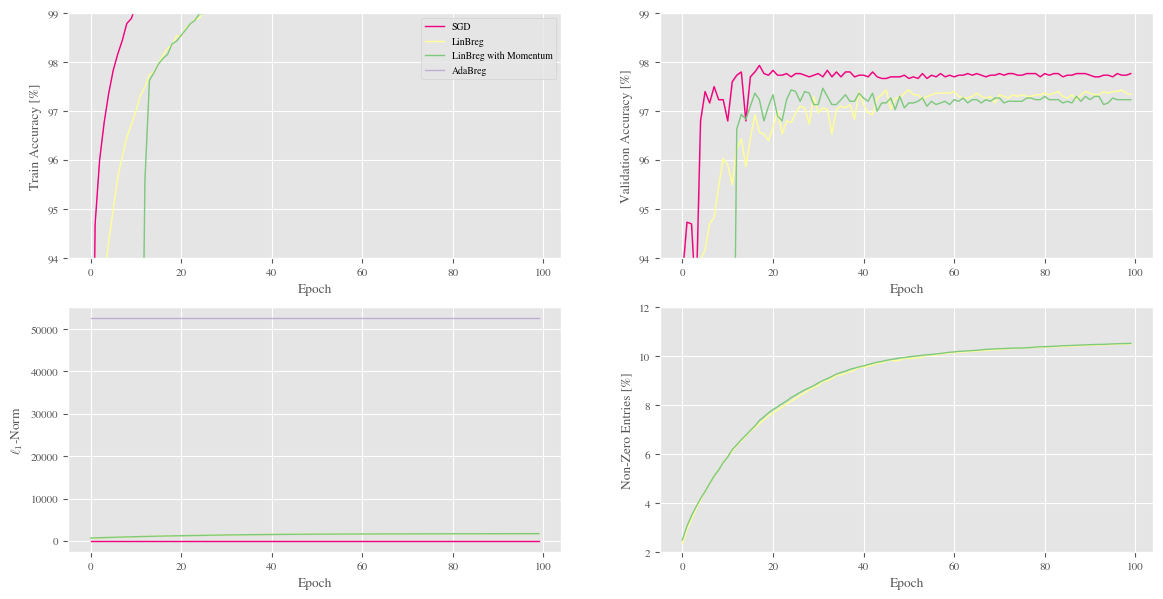

In [ ]:
fig, ax = plt.subplots(2,2)
ax = np.ravel(ax)

for param in params:
    plot_training_stats(ax, keys, param['result'], color = param['color'], label = param['label'])

# Specify axes
## Train Acc
ax[0].set_ylabel('Train Accuracy [%]')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(94, 99)
## Validation Acc
ax[1].set_ylabel('Validation Accuracy [%]')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(94, 99)
## L1-Norm
ax[2].set_ylabel('$\ell_1$-Norm')
ax[2].set_xlabel('Epoch')
## Sparsity
ax[3].set_ylabel('Non-Zero Entries [%]')
ax[3].set_xlabel('Epoch')
ax[3].set_ylim(2, 12);

# Legend
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='best',frameon=1,prop={'size': 7}, ncol = 1)

# Adjust size
width = 14
height = 7
fig.set_size_inches(width, height)

fig.savefig("4.3_1.png")
fig.savefig("4.3_1.pdf")

# **ConvNet Model** (SECTION 4.4 in the paper)

**NOTICE:  To test different optimizers, change the optim varaiable in conf to Adabreg, LinBreg and LinBregM**

## Fix the random seed

In [ ]:
random_seed = 2
cf.seed_torch(random_seed)

## Configure the experiment

In [ ]:
conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':True, 'num_workers':4, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"LinBregM", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

## Initiate the model

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)
best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

## Draw the model

In [ ]:
x = torch.rand(100, 1, 28, 28)
y = model(x)
make_dot(y.mean(), params=dict(model.named_parameters())).render('model', format='png')

'model.png'

## Weight initialization

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0],ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2],ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    model = model.to(conf.device)
    
    return model

model = init_weights(conf,model)

## Optimizer

In [ ]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "LinBregM":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':0.9,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':0.9,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':0.9}])        
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2,'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

## Dataset

In [ ]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting BregmanLearning-main/FashionMNIST/raw/train-images-idx3-ubyte.gz to BregmanLearning-main/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting BregmanLearning-main/FashionMNIST/raw/train-labels-idx1-ubyte.gz to BregmanLearning-main/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting BregmanLearning-main/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to BregmanLearning-main/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting BregmanLearning-main/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to BregmanLearning-main/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## History and Runs

In [ ]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {}
val_hist = {}

## Training

In [ ]:
# -----------------------------------------------------------------------------------
# Reinit weigts and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])           

    # ------------------------------------------------------------------------
    # validation step
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)   


    scheduler.step(train_data['loss'])
    print("Learning rate:",opt.param_groups[0]['lr'])
    best_model(train_data['acc'], val_data['acc'], model=model)

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------
Train Accuracy: 0.5190526315789473
Train Loss: 572.0050950050354
--------------------------------------------------
Validation Accuracy: 0.7053333333333334
Non-zero kernels: 0.010817307692307692
Linear sparsity: 0.9928221711798839
Overall sparsity: 0.5607187584619551
Node sparsity: [1.0, 1.0]
Regularization values per group: [20.266797304153442, 1911.5814025878908, 0.0]
Learning rate: 0.07
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------
Train Accuracy: 0.7324561403508771
Train Loss: 322.1764988899231
--------------------------------------------------
Validation Accuracy: 0.7426666666666667
Non-zero kernels: 0.010817307692307692
Linear sparsity: 0.9907368230174082
Overall sparsity: 0.5595510086650419
Node sparsity: [1.0, 1.0]
Regularization values per group: [21.001478910446

# **ResNet Model** (SECTION 4.5 in the paper)

**NOTICE:  To test different optimizers, change the optim varaiable in conf to Adabreg, LinBreg and LinBregM**

In [ ]:
conf_args = {#
    # data specification
    'data_file':"../../Data", 'train_split':0.95, 'data_set':"CIFAR10", 'download':True,
    # cuda
    'use_cuda':True, 'num_workers':4, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.001, 'lamda_0':0.1, 'lamda_1':0.0, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,5,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}
conf = cf.Conf(**conf_args)

SyntaxError: ignored

In [ ]:
# -----------------------------------------------------------------------------------
# define the model and an instance of the best model class
# -----------------------------------------------------------------------------------
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std, 'im_size':conf.im_shape[1],
                'im_channels':conf.im_shape[0]}    

model = ResNet18()
best_model = train.best_model(ResNet18())
    
# sparsify
maf.sparse_bias_uniform_(model, 0,conf.r[0])
maf.sparse_weight_normal_(model, conf.r[1])
maf.sparsify_(model, conf.sparse_init, conv_group = conf.conv_group)
model = model.to(conf.device)

In [ ]:
def init_opt(conf, model):
    # Get access to different model parameters
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    weights_batch = maf.get_weights_batch(model)
    biases = maf.get_bias(model)

   
    if conf.conv_group:
        reg_0 = reg.reg_l1_l2_conv(conf.lamda_0)
    else:
        reg_0 = reg.reg_l1(conf.lamda)
        
    reg_1 = reg.reg_l1(conf.lamda_1)
        
        
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg_0, 'momentum':conf.beta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg_1, 'momentum':conf.beta},
                          {'params': weights_batch, 'lr' : conf.lr, 'momentum':beta},
                          {'params': biases, 'lr': conf.lr, 'momentum':beta}])
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg_0},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg_1},
                           {'params': weights_batch, 'lr' : conf.lr, 'momentum':conf.beta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg_0 =  reg.reg_l1(lamda=conf.lamda_0)
            
            loss_1 = 0
            for w in maf.get_weights_conv(model):
                loss_1 += reg_1(w)
                
            loss_0 = 0
            for w in maf.get_weights_linear(model):
                loss_0 += reg_0(w)
                
            return loss_0 + loss_1
            conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

In [ ]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {key: [] for key in tracked}
val_hist = {key: [] for key in tracked}

In [ ]:
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0, conf.r[0])
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[1],ltype=nn.Conv2d)
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group = conf.conv_group)
    model = model.to(conf.device)
    
    return model

In [ ]:
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])        

    # ------------------------------------------------------------------------
    # validation step
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)


    scheduler.step(train_data['loss'])
    print("Learning rate:",opt.param_groups[0]['lr'])
    best_model(train_data['acc'], val_data['acc'], model=model)

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------
Train Accuracy: 0.22821052631578947
Train Loss: 1071.8289530277252
--------------------------------------------------
Validation Accuracy: 0.2996
Non-zero kernels: 0.010031360566098425
Linear sparsity: 1.0
Overall sparsity: 0.010454346118789518
Node sparsity: [1.0]
Regularization values per group: [1422.5256067276002, 0.0, 0.0, 0.0]
Learning rate: 0.001
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1


KeyboardInterrupt: ignored

# **VGG-16 and VGG-13 Models** (Further Investigation)

**NOTICE: In order to test different vgg model, you need to change the initialzation of the model to the desired one.                               To test different optimizers, change the optim varaiable in conf to Adabreg, LinBreg and LinBregM**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from utils.datasets import get_data_set, GaussianSmoothing
from models.fully_connected import fully_connected
from models.resnet import ResNet18
from models.mnist_conv import mnist_conv

In [ ]:
from typing import Union, List, Dict, Any, cast

import torch
import torch.nn as nn

#from .._internally_replaced_utils import load_state_dict_from_url
#from ..utils import _log_api_usage_once


__all__ = [
    "VGG",
    "vgg11",
    "vgg11_bn",
    "vgg13",
    "vgg13_bn",
    "vgg16",
    "vgg16_bn",
    "vgg19_bn",
    "vgg19",
]


model_urls = {
    "vgg11": "https://download.pytorch.org/models/vgg11-8a719046.pth",
    "vgg13": "https://download.pytorch.org/models/vgg13-19584684.pth",
    "vgg16": "https://download.pytorch.org/models/vgg16-397923af.pth",
    "vgg19": "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth",
    "vgg11_bn": "https://download.pytorch.org/models/vgg11_bn-6002323d.pth",
    "vgg13_bn": "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth",
    "vgg16_bn": "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth",
    "vgg19_bn": "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth",
}


class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 1
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs["init_weights"] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    
    return model


def vgg11(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg11", "A", False, pretrained, progress, **kwargs)


def vgg11_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg11_bn", "A", True, pretrained, progress, **kwargs)


def vgg13(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg13", "B", False, pretrained, progress, **kwargs)


def vgg13_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg13_bn", "B", True, pretrained, progress, **kwargs)


def vgg16(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg16", "D", False, pretrained, progress, **kwargs)


def vgg16_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg16_bn", "D", True, pretrained, progress, **kwargs)


def vgg19(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg19", "E", False, pretrained, progress, **kwargs)


def vgg19_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg19_bn", "E", True, pretrained, progress, **kwargs)

In [ ]:
model = vgg13(num_classes=36)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [ ]:
random_seed = 2
cf.seed_torch(random_seed)

In [ ]:
conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"CIFAR10", 'download':True,
    # cuda
    'use_cuda':True, 'num_workers':4, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0],ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2],ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    model = model.to(conf.device)
    
    return model

model = init_weights(conf,model)

In [ ]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "LinBregM":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':0.9,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':0.9,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':0.9}])        
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2,'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

In [ ]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(train_loader)

In [ ]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {}
val_hist = {}

In [ ]:
# -----------------------------------------------------------------------------------
# Reinit weigts and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])           

    # ------------------------------------------------------------------------
    # validation step
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)   


    scheduler.step(train_data['loss'])
    print("Learning rate:",opt.param_groups[0]['lr'])
   

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------
Train Accuracy: 0.09863157894736842
Train Loss: 183818.99491477013
--------------------------------------------------
Validation Accuracy: 0.094
Non-zero kernels: 0.048775350775075055
Linear sparsity: 0.6433702201242728
Overall sparsity: 0.6000481570366227
Node sparsity: [1.0, 1.0, 1.0]
Regularization values per group: [27084.469100189213, 3688383.578125, 0.0]
Learning rate: 0.07
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------
Train Accuracy: 0.10183157894736843
Train Loss: 858.8366746902466
--------------------------------------------------
Validation Accuracy: 0.1088
Non-zero kernels: 0.048775350775075055
Linear sparsity: 0.6433701950585001
Overall sparsity: 0.6000481337963053
Node sparsity: [1.0, 1.0, 1.0]
Regularization values per group: [27084.469100189213, 3688437.670